In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv("morgan_fingerprints.csv")
df = pd.read_csv("drd2_cleaned_dataset.csv")

y = df["pIC50"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (890, 990)
y shape: (890,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape)

(712, 990) (178, 990)


In [4]:
rf_morgan = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_morgan.fit(X_train, y_train)

# Evaluate quickly
y_pred = rf_morgan.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2, rmse

(0.630412993623086, np.float64(0.6683373262104234))

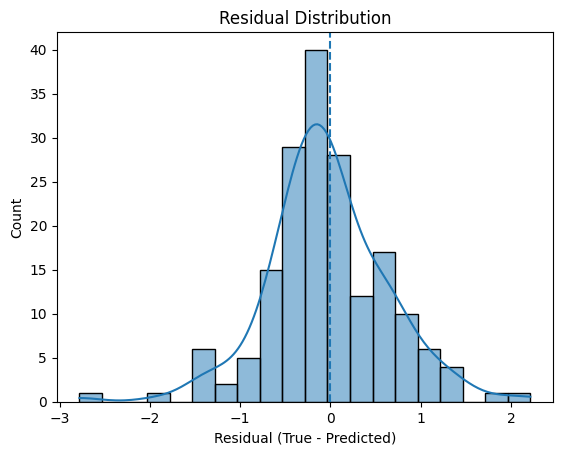

Mean residual: -0.038121130279518495
Std residual: 0.6691314796684877


In [5]:
residuals = y_test - y_pred

plt.figure()
sns.histplot(residuals, kde=True)
plt.axvline(0, linestyle="--")
plt.xlabel("Residual (True - Predicted)")
plt.title("Residual Distribution")
plt.show()

print("Mean residual:", residuals.mean())
print("Std residual:", residuals.std())

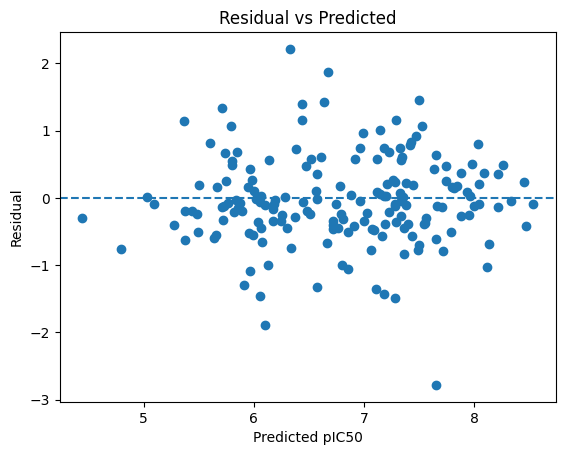

In [6]:
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted pIC50")
plt.ylabel("Residual")
plt.title("Residual vs Predicted")
plt.show()

In [7]:
error_df = pd.DataFrame({
    "True": y_test,
    "Pred": y_pred,
    "Residual": residuals,
    "AbsError": np.abs(residuals)
})

error_df_sorted = error_df.sort_values("AbsError", ascending=False)

error_df_sorted.head(10)

,True,Pred,Residual,AbsError
656,4.870000,7.651451,-2.781451,2.781451
215,8.540005,6.324970,2.215035,2.215035
394,4.213968,6.106423,-1.892455,1.892455
834,8.537602,6.671678,1.865924,1.865924
265,5.801343,7.286203,-1.484860,1.484860
598,4.600000,6.057073,-1.457073,1.457073
227,8.960189,7.503352,1.456838,1.456838
570,5.760000,7.185194,-1.425194,1.425194
198,8.059982,6.640836,1.419146,1.419146
306,7.823909,6.434730,1.389179,1.389179


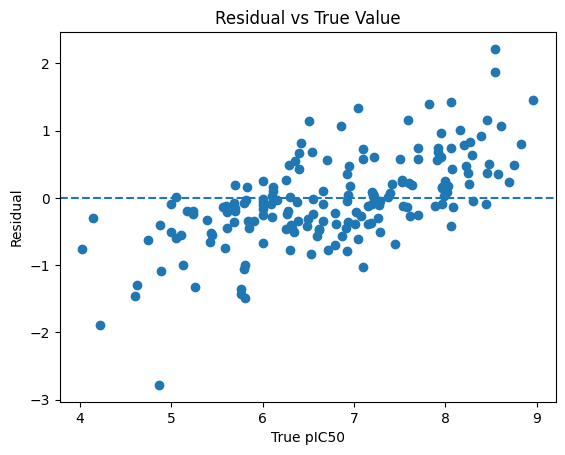

In [8]:
plt.figure()
plt.scatter(y_test, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("True pIC50")
plt.ylabel("Residual")
plt.title("Residual vs True Value")
plt.show()

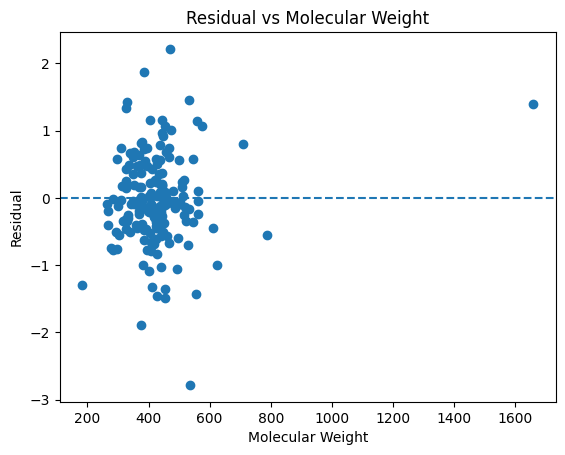

In [11]:
desc = pd.read_csv("rdkit_descriptors.csv")

# Ensure same indexing as df used in split
desc = desc.reset_index(drop=True)
df = df.reset_index(drop=True)

mw = desc["MolWt"]

# Now use .loc with y_test index
mw_test = mw.loc[y_test.index]

plt.figure()
plt.scatter(mw_test, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Molecular Weight")
plt.ylabel("Residual")
plt.title("Residual vs Molecular Weight")
plt.show()

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(rf_morgan, X_train, y_train, cv=kf, scoring="r2")

cv_r2, cv_r2.mean(), cv_r2.std()

(array([0.36039097, 0.26195059, 0.22170298, 0.52958966, 0.36504442]),
 np.float64(0.34773572473582165),
 np.float64(0.10655885038422974))

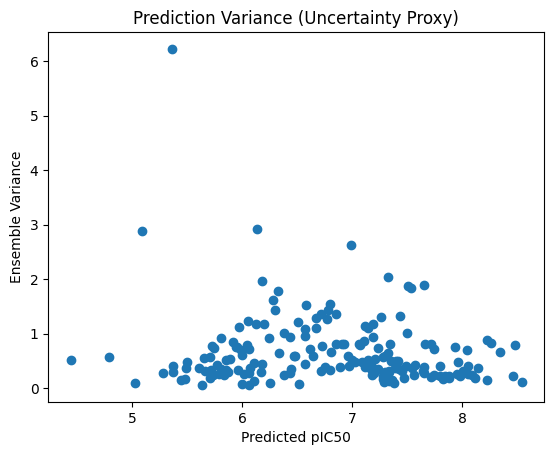

In [13]:
tree_preds = np.stack([tree.predict(X_test) for tree in rf_morgan.estimators_])
prediction_variance = tree_preds.var(axis=0)

plt.figure()
plt.scatter(y_pred, prediction_variance)
plt.xlabel("Predicted pIC50")
plt.ylabel("Ensemble Variance")
plt.title("Prediction Variance (Uncertainty Proxy)")
plt.show()

In [14]:
np.corrcoef(prediction_variance, np.abs(residuals))

array([[1.        , 0.29418939],
       [0.29418939, 1.        ]])